In [ ]:
#Importing libraries
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras import utils
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
import keras
import imageio
from PIL import Image
from sklearn.model_selection import train_test_split
import seaborn as sns

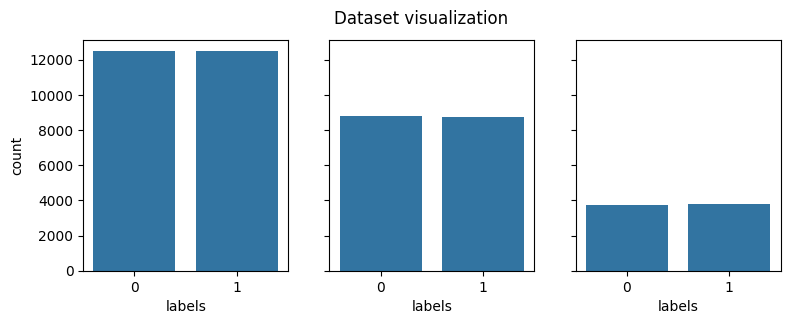

In [ ]:
#Dataset distribution visualization
df = pd.read_csv("/kaggle/input/cat-dog-images-for-classification/cat_dog.csv")
train_df, test_df = train_test_split(df, test_size=0.3, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(9, 3))
sns.countplot(x='labels', data=df, ax=ax[0])
sns.countplot(x='labels', data=train_df, ax=ax[1])
sns.countplot(x='labels', data=test_df, ax=ax[2])
fig.suptitle('Dataset visualization')
plt.show()

<ipython-input-5-e53bd7524989>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread("/kaggle/input/cat-dog-images-for-classification/cat_dog/cat.12461.jpg")


(352, 349, 3)


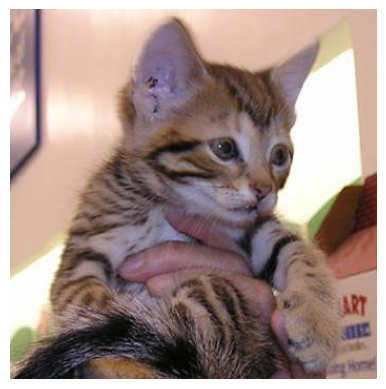

In [ ]:
#Displaying and inspecting the image
img = imageio.imread("/kaggle/input/cat-dog-images-for-classification/cat_dog/cat.12461.jpg")
plt.imshow(img)
print(img.shape)
plt.axis('off')
plt.show()

In [ ]:
# Data Preprocessing

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cat-dog-images-for-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1840863%2F3004992%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240404%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240404T202758Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dae3daacf2b3e5ff5161b7a6d3271c1063c3664d33652c3a97a0d9459714a8185a3aa90f3e7bc38d421beb39fcf6958d5cf96f1e19133eaea8c58babdafdb0bc5996944059f464e7ae5fecaf7a92cc979f328c5d979949fd442f97d4250b27e7b7a0731c020a6d4fd2bb794c335acab97f70e3822e272a11c3d47783dce1147fbb45e3ea1afacd8173ebab299b0deb678900ecf43134610372b295430cc6b88c6948dd380112d0573fe819f76313d1396ebae2e6f55e237a3e4ed0ea6ad6c15eb5793c3e1a15f117bbfbd34bf3ffff704e22cbacd05e53a716e23aa9aa62ecc71ea8a4a94a19f8945dbc31c71b72a02939bc18b9d539dddf0ef3750b33b9ec4b7'

KAGGLE_INPUT_PATH = '/kaggle/input'
KAGGLE_WORKING_PATH = '/kaggle/working'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
    os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
    pass
try:
    os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
    pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 571060749 bytes downloaded
Downloaded and uncompressed: cat-dog-images-for-classification
Data source import complete.


In [ ]:
#Data loading and preprocessing
import pandas as pd
import os
import imageio
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical  # Import to_categorical from tensorflow.keras.utils

# Loading data and preprocessing
df = pd.read_csv("/kaggle/input/cat-dog-images-for-classification/cat_dog.csv")
train_df, test_df = train_test_split(df, test_size=0.3, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

temp = []
for img_name in train_df.image:
    img_path = os.path.join("../input/cat-dog-images-for-classification/cat_dog", img_name)
    img = imageio.imread(img_path)
    img = np.array(Image.fromarray(img).resize((32, 32))).astype('float32')
    temp.append(img)
train_x = np.stack(temp)

temp = []
for img_name in test_df.image:
    img_path = os.path.join("../input/cat-dog-images-for-classification/cat_dog", img_name)
    img = imageio.imread(img_path)
    img = np.array(Image.fromarray(img).resize((32, 32))).astype('float32')
    temp.append(img)
test_x = np.stack(temp)

# Normalizing pixel values
train_x /= 255.0
test_x /= 255.0

# Encoding labels
lb = LabelEncoder()
train_y = lb.fit_transform(train_df.labels)
test_y = lb.transform(test_df.labels)
num_classes = len(lb.classes_)
train_y_categorical = to_categorical(train_y, num_classes)  # Use to_categorical directly
test_y_categorical = to_categorical(test_y, num_classes)  # Use to_categorical directly


<ipython-input-10-ad2509567cb8>:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)
<ipython-input-10-ad2509567cb8>:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


In [ ]:
# Model Architecture
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Defining early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model
history = model.fit(train_x, train_y_categorical, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluating the model
test_loss, test_accuracy = model.evaluate(test_x, test_y_categorical)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/20
438/438 [==============================] - 9s 7ms/step - loss: 0.6614 - accuracy: 0.5987 - val_loss: 0.6009 - val_accuracy: 0.6834
Epoch 2/20
438/438 [==============================] - 2s 5ms/step - loss: 0.5739 - accuracy: 0.7034 - val_loss: 0.5273 - val_accuracy: 0.7369
Epoch 3/20
438/438 [==============================] - 2s 5ms/step - loss: 0.5050 - accuracy: 0.7543 - val_loss: 0.4850 - val_accuracy: 0.7651
Epoch 4/20
438/438 [==============================] - 3s 6ms/step - loss: 0.4612 - accuracy: 0.7832 - val_loss: 0.4605 - val_accuracy: 0.7900
Epoch 5/20
438/438 [==============================] - 3s 6ms/step - loss: 0.4108 - accuracy: 0.8115 - val_loss: 0.4436 - val_accuracy: 0.7877
Epoch 6/20
438/438 [==============================] - 2s 5ms/step - loss: 0.3780 - accuracy: 0.8273 - val_loss: 0.4541 - val_accuracy: 0.7849
Epoch 7/20
438/438 [==============================] - 2s 5ms/step - loss: 0.3398 - accuracy: 0.8494 - val_loss: 0.5071 - val_accuracy: 0.7729
Epoch 

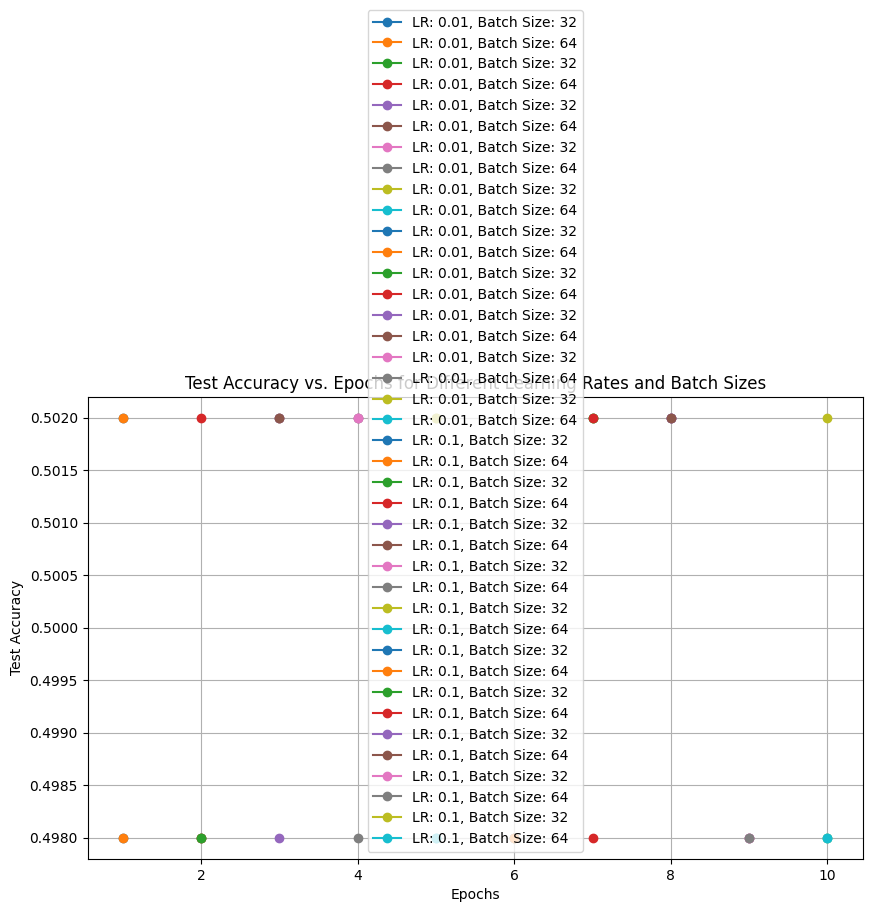

In [ ]:
#Hyperparameter tuning
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import keras

# Defining a function to create the Keras model
def create_model(learning_rate=0.001, dropout_rate=0.0):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model with Adam optimizer and specified learning rate
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Defining hyperparameters
learning_rates = [0.01, 0.1]
epochs = range(1, 11)  # Reduce the number of epochs
batch_sizes = [32, 64]

# Results storage
results = []

# Iterating over learning rates, epochs, and batch sizes
for lr in learning_rates:
    for epoch in epochs:
        for batch_size in batch_sizes:
            # Creating and compile model
            model = create_model(learning_rate=lr)

            # Training the model
            history = model.fit(train_x, train_y_categorical, epochs=epoch, batch_size=batch_size, validation_split=0.2, verbose=0)

            # Evaluating the model
            test_loss, test_accuracy = model.evaluate(test_x, test_y_categorical, verbose=0)

            # Saving results
            results.append({'learning_rate': lr, 'epochs': epoch, 'batch_size': batch_size, 'test_accuracy': test_accuracy})

# Plotting results
plt.figure(figsize=(10, 6))
for result in results:
    plt.plot(result['epochs'], result['test_accuracy'], marker='o', label=f"LR: {result['learning_rate']}, Batch Size: {result['batch_size']}")
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Epochs for Different Learning Rates and Batch Sizes')
plt.legend()
plt.grid(True)
plt.show()

235/235 [==============================] - 1s 5ms/step


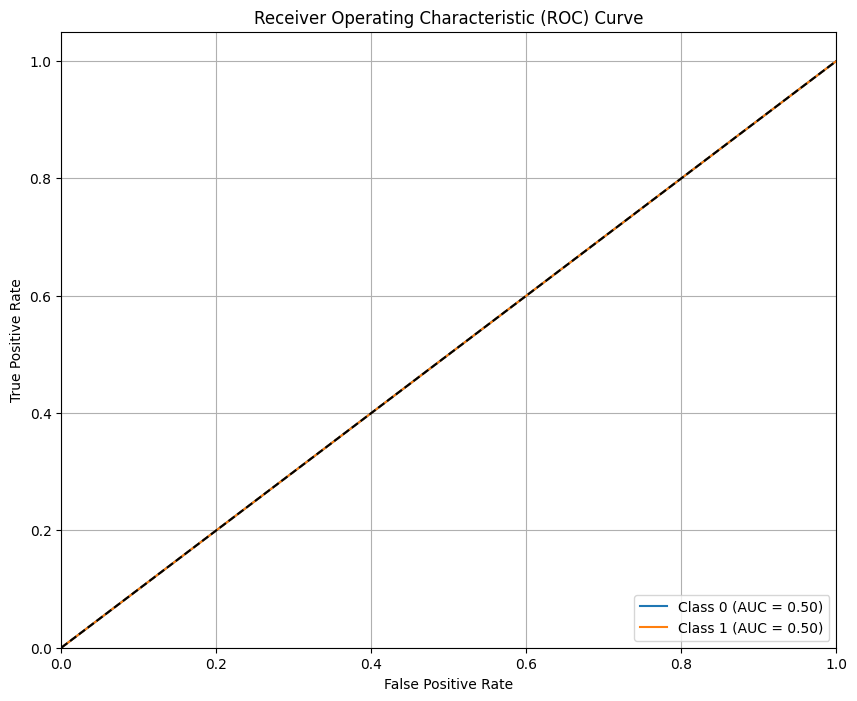

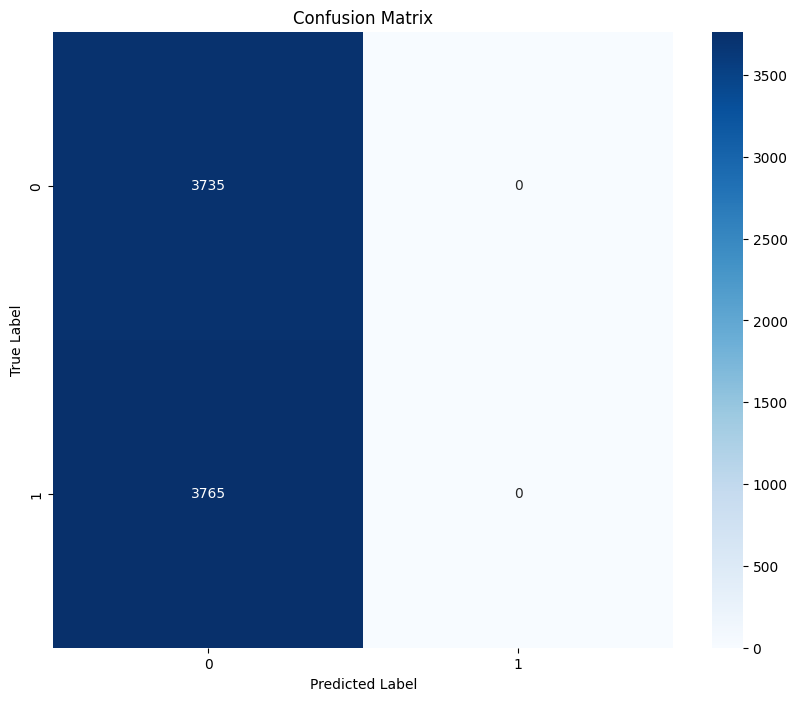

In [ ]:
#Model Evaluation: ROC Curve and Confusion Matrix
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

# Computing predicted probabilities for each class using test data
test_probs = model.predict(test_x)

# Computing ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y_categorical[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Calculating predictions
test_predictions = np.argmax(test_probs, axis=1)

# Calculating the confusion matrix
conf_matrix = confusion_matrix(test_y, test_predictions)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Evaluating the final model on the test dataset
final_test_loss, final_test_accuracy = model.evaluate(test_x, test_y_categorical)

# Printing the test loss and accuracy
print(f"Final Test Loss: {final_test_loss}")
print(f"Final Test Accuracy: {final_test_accuracy}")

235/235 [==============================] - 1s 3ms/step - loss: 0.7135 - accuracy: 0.4980
Final Test Loss: 0.713516891002655
Final Test Accuracy: 0.49799999594688416
